##### 1. Install and import necessary libraries

In [ ]:
import ee
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio     
import numpy as np  

from rasterio.warp import calculate_default_transform, reproject, Resampling

##### 2. Connect to GEE

In [2]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project="ee-ogalloethel")

##### 3. Define AOI

In [40]:
# Base directory whee data is stored
base_dir = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data"

# Verify the directory exists
if not os.path.exists(base_dir):
    print(f"WARNING: Base directory does not exist: {base_dir}")
    print("Please check your path!")
else:
    print(f"✓ Base directory found: {base_dir}")

✓ Base directory found: C:\Users\Ethel Ogallo\Documents\ZFL1\Data


In [41]:
# Import shapefile and set as the AOI
# Update the path to your shapefile as needed
shapefile = gpd.read_file(os.path.join(base_dir,'baringo_bbox/baringo_bbox.shp'))

shape = shapefile.geometry[0]  # assuming one polygon
geo_json = shape.__geo_interface__
study_area = ee.Geometry(geo_json)

##### 4. Generic functons to export data from GEE

In [4]:

# 1. Function to clip an image to the area of interest (AOI)
def clip_to_aoi(image):
    """
    Clip the image to the specified area of interest.
    """
    if not isinstance(image, ee.Image):
        raise TypeError("Input must be an ee.Image")    
    return image.clip(study_area)


# Function to export an image to Google Drive
def export_image_to_drive(image, year, label='image', folder='Exports', scale=30):
    """ 
    Export an image to Google Drive.
    Args:
        image (ee.Image): The image to export.
        year (int): The year associated with the image.
        label (str): A label for the export task.
        folder (str): The folder in Google Drive where the image will be saved.
        scale (int): The scale of the exported image in meters per pixel.
    """
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'{label}_{year}',
        folder=folder,
        fileNamePrefix=f'{label}_{year}',
        scale=scale,
        region=study_area,
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )
    task.start()
    print(f"Started export task: {label}_{year}")


##### 5. Download DEM and SLope

In [5]:
# Function to get DEM and slope
def get_dem():
    """
    Retrieve DEM, slope.

    Returns:
        If apply_slope_mask:
            Tuple[ee.Image, ee.Image, ee.Image]: (DEM image, slope image, slope mask)
        Else:
            Tuple[ee.Image, ee.Image]: (DEM image, slope image)
    """
    # Load and mosaic DEM, then clip to AOI
    dem = (ee.ImageCollection("COPERNICUS/DEM/GLO30")
           .filterBounds(study_area)
           .mosaic()
           .select('DEM'))
    dem = clip_to_aoi(dem).toFloat().reproject(crs='EPSG:32736', scale=30)

    # Calculate slope
    slope = ee.Terrain.slope(dem).rename('Slope')

    return dem.rename('DEM'), slope


In [6]:
# Get DEM and slope
dem, slope = get_dem()

# Export or process each as needed
export_image_to_drive(dem, year='DEM', label='DEM', folder='DEM')
export_image_to_drive(slope, year='Slope', label='Slope', folder='DEM')

Started export task: DEM_DEM
Started export task: Slope_Slope


In [ ]:
# Function to reproject a raster to match another raster's CRS and dimensions
def reproject_to_match(src_path, ref_path, dst_path):
    with rasterio.open(ref_path) as ref:
        ref_crs = ref.crs
        ref_transform = ref.transform
        ref_width = ref.width
        ref_height = ref.height

    with rasterio.open(src_path) as src:
        dst_array = np.empty((ref_height, ref_width), dtype=src.dtypes[0])

        reproject(
            source=src.read(1),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.bilinear
        )

        profile = src.profile.copy()
        profile.update({
            'crs': ref_crs,
            'transform': ref_transform,
            'width': ref_width,
            'height': ref_height
        })

        with rasterio.open(dst_path, 'w', **profile) as dst:
            dst.write(dst_array, 1)

# Usage example:
reproject_to_match(
    src_path=os.path.join(base_dir,'DEM\Slope.tif'),
    ref_path=os.path.join(base_dir,'Data\DEM\DEM.tif'),
    dst_path=os.path.join(base_dir,'DEM\Slope_aligned.tif')
)


##### 6. Download Landsat LST 2015-2025
A cloud mask was appled prior to download

In [8]:
# Function to get LST image for a specific year 
# And apply cloud mask
def cloud_mask(image):
    cloud_shadow_bitmask = 1 << 3  # bit 3 cloud shadow
    cloud_bitmask = 1 << 5         # bit 5 cloud
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa.bitwiseAnd(cloud_bitmask).eq(0))
    return image.updateMask(mask)


def download_lst(year):
    """ 
    Download Landsat 8 LST for a specific year.
    Args:
        year (int): The year for which to download the LST image.
    Returns:   
        ee.Image: The mean LST image for the specified year.
    """
    lst_col = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') # Landsat 8 Collection 2 Tier 1
               .filterBounds(study_area)
               .filterDate(f'{year}-01-01', f'{year}-12-31')
               .map(cloud_mask)  # Apply cloud mask
               .map(lambda img: img.select('ST_B10') # Select the LST band
                    .multiply(0.00341802).add(149.0) # Scale factor to convert DN to Kelvin
                    .subtract(273.15)  # Convert Kelvin to Celsius
                    .rename('LST'))
               .map(clip_to_aoi))
    return lst_col.mean().set({'year': year})


In [ ]:
# Loop through the years and export LST images
years = list(range(2015, 2026))

# Get the LST image for each year and export it to Google Drive
for year in years: 
    lst = download_lst(year)
    export_image_to_drive(lst, year, label='LST_mean', folder='LST')


##### 7. Compute NDVI Standard Deviation and Oscillation 2015-2025

In [9]:
# Function to compute NDVI statistics for Sentinel-2 images
def compute_ndvi(year):
    """ 
    Compute NDVI for Sentinel-2 images for a specific year.
    Args:
        year (int): The year for which to compute NDVI.
    Returns:   
        ee.Image: The NDVI standard deviation and range for the specified year.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda image: image.addBands(
              image.normalizedDifference(['B8', 'B4']).rename('NDVI')
              ))
          .select('NDVI'))

    # Calculate NDVI standard deviation
    ndvi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'NDVI_SD_{year}')

    # Calculate NDVI range
    ndvi_min = s2.reduce(ee.Reducer.min())
    ndvi_max = s2.reduce(ee.Reducer.max())
    ndvi_range = ndvi_max.subtract(ndvi_min).rename(f'NDVI_Range{year}')
    
    return ndvi_std, ndvi_range

In [ ]:
# Loop through the years and compute NDVI statistics
years = list(range(2015, 2026))

# Export NDVI statistics to Google Drive
for year in years:
    ndvi_std, ndvi_range = compute_ndvi(year)
    export_image_to_drive(ndvi_std, year, label='NDVI_SD', folder='NDVI')
    export_image_to_drive(ndvi_range, year, label='NDVI_Range', folder='NDVI')


##### 8. Compute max NDWI from S2 2015-2025

In [10]:
# Function to compute NDWI statistics for Sentinel-2 images
def compute_ndwi(year):
    """
    Compute maximum NDWI for Sentinel-2 images for a given year.
    Args:
        year (int): Year of interest.
    Returns:
        ee.Image: Max NDWI image.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.addBands(
              img.normalizedDifference(['B8', 'B3'])
                 .rename('NDWI')
                 .toFloat()
          ))
          .select('NDWI'))
    
    ndwi_max = s2.max().rename(f'NDWI_Max_{year}')
    return ndwi_max

In [ ]:
# Loop through the years and compute NDVI statistics
years = list(range(2015, 2026))

# Export NDVI statistics to Google Drive
for year in years:
    ndwi_max = compute_ndwi(year)
    export_image_to_drive(ndwi_max, year, label='NDWI_Max', folder='NDWI')


##### 9. Download S1 VV and VH GRD from 2015-2025

In [38]:
# Function to get Sentinel-1 minimum backscatter for a given year and polarization
def get_sentinel1_min(year, pol='VV', orbit_pass='ASCENDING'):
    """
    Get annual minimum Sentinel-1 backscatter (dB) for given polarization.

    Args:
        year (int): Year of interest.
        pol (str): Polarization ('VV' or 'VH').
        orbit_pass (str): Orbit pass ('ASCENDING' or 'DESCENDING').
    Returns:
        ee.Image: Minimum Sentinel-1 backscatter image for the specified year and polarization.
    """
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterDate(start, end)
          .filterBounds(study_area)
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.eq('orbitProperties_pass', orbit_pass))
          .filter(ee.Filter.eq('resolution_meters', 10))
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', pol))
          .select(pol)
         )
    
    s1_min = s1.min().rename(f'S1_{pol}_Min_{year}')
    return clip_to_aoi(s1_min)


In [39]:
# Loop through the years and export Sentinel-1 images
# for both VV and VH polarizations
#years = list(range(2015, 2026))

for year in years:
    for pol in ['VV', 'VH']:
        img = get_sentinel1_min(year, pol=pol)

        task = ee.batch.Export.image.toDrive(
            image=img,
            description=f'S1_{pol}_Min_{year}',
            folder=f'S1_{pol}',
            fileNamePrefix=f'S1_{pol}_Min_{year}',
            region=study_area.bounds().getInfo()['coordinates'],
            scale=10,
            crs='EPSG:4326',
            maxPixels=1e13
        )

        task.start()
        print(f'Started export task for {pol} {year}')


Started export task for VV 2015
Started export task for VH 2015
Started export task for VV 2016
Started export task for VH 2016
Started export task for VV 2017
Started export task for VH 2017
Started export task for VV 2018
Started export task for VH 2018
Started export task for VV 2019
Started export task for VH 2019
Started export task for VV 2020
Started export task for VH 2020
Started export task for VV 2021
Started export task for VH 2021
Started export task for VV 2022
Started export task for VH 2022
Started export task for VV 2023
Started export task for VH 2023
Started export task for VV 2024
Started export task for VH 2024
Started export task for VV 2025
Started export task for VH 2025


#### Feature clasification using Random Forest

In [ ]:
!pip install --quiet geopandas rasterio scikit-learn matplotlib scipy pandas

In [59]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score, f1_score
import rasterio.warp
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import rowcol, from_bounds
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.io import MemoryFile
from collections import Counter
import folium
import os
import getpass
import requests
import math


In [13]:
# Define AOI extents
extent = shapefile.total_bounds
print(extent)

# # Center point for map view
# center_lat = (aoi_extent[1] + aoi_extent[3]) / 2
# center_lon = (aoi_extent[0] + aoi_extent[2]) / 2

[35.55784244  0.12084055 36.42238567  0.89870433]


**Importing the training points**   
ensuring they are in the right CRS

In [ ]:

# Importing the training points and setting the CRS
# Define the coordinate reference system (CRS) for the training points
gdf = gpd.read_file(os.path.join(base_dir, 'baringo_training_points.shp'))

# # Define the desired CRS using the CRS from the LST raster
with rasterio.open(os.path.join(base_dir,"LST\LST_mean_2025.tif")) as src:
    lst_crs = src.crs

if gdf.crs != lst_crs:
    gdf = gdf.to_crs(lst_crs)

# Display the first few rows of the GeoDataFrame
gdf.iloc[:-10]


,id,class,geometry
0,1,water,POINT (36.06711 0.56802)
1,2,water,POINT (36.04937 0.67043)
2,3,water,POINT (36.09725 0.47869)
3,4,water,POINT (36.09869 0.47104)
4,5,water,POINT (36.07187 0.34713)
...,...,...,...
60,60,wetland,POINT (36.0458 0.36288)
61,61,wetland,POINT (36.04572 0.36396)
62,62,wetland,POINT (36.0472 0.36442)
63,63,wetland,POINT (36.04681 0.36795)


*Visualizing the training data ensuring they are within the bounds*

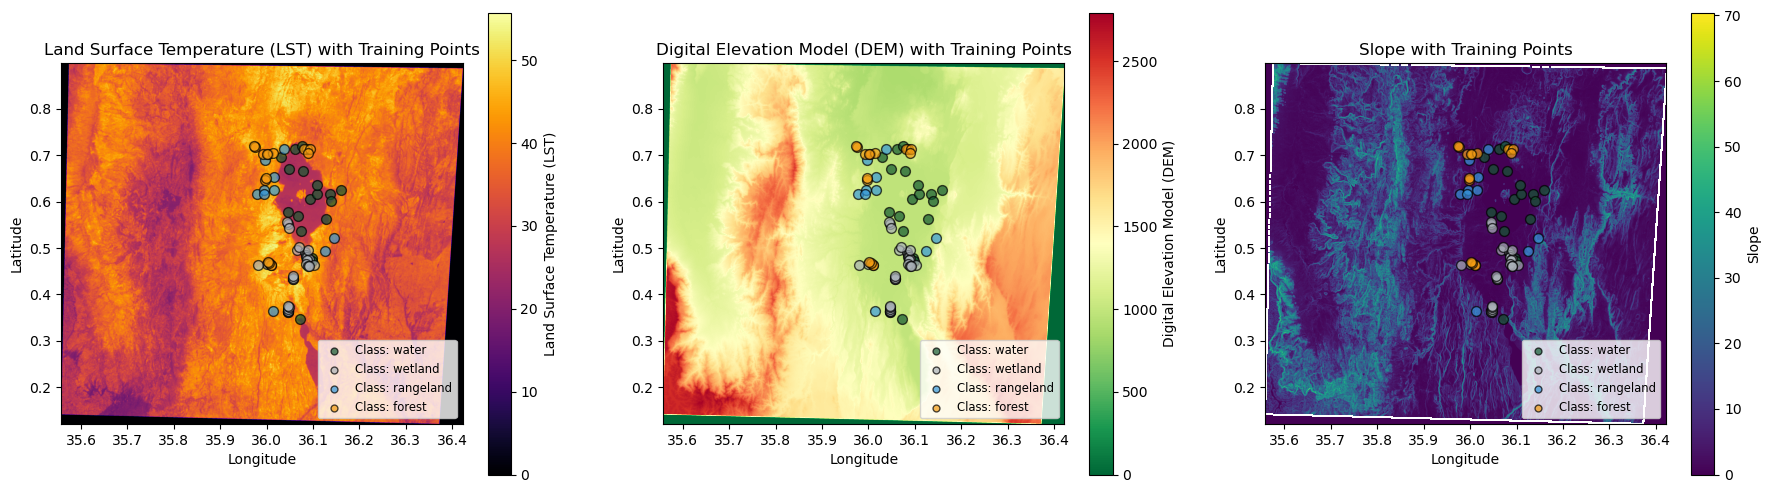

In [ ]:

lst = rasterio.open(os.path.join(base_dir, "LST", "masked_rasters/LST_mean_2015.tif"))
dem = rasterio.open(os.path.join(base_dir, "DEM", "masked_rasters/DEM.tif"))
slope = rasterio.open(os.path.join(base_dir, "DEM", "masked_rasters/Slope_aligned.tif"))

# List of raster layers, their titles, and optional colormaps
rasters = [
    (lst, "Land Surface Temperature (LST)", "inferno"),
    (dem, "Digital Elevation Model (DEM)", "RdYlGn_r"),
    (slope, "Slope", "viridis"),
]

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 10))
axes = axes.flatten()

# Extract unique land cover classes from training points
classes = gdf['class'].unique()
colors = ['#145a32', '#abb2b9', '#3498db', '#f39c12']  # Assign a unique color per class

# Loop through each raster layer and corresponding subplot
for i, (raster, title, *cmap) in enumerate(rasters):
    ax = axes[i]
    colormap = cmap[0] if cmap else 'gray'

    # Read raster data as numpy array
    raster_data = raster.read(1)

    # Display raster with extent and colormap
    im = ax.imshow(
        raster_data,
        cmap=colormap,
        extent=[extent[0], extent[2], extent[1], extent[3]],
        origin='upper'
    )
    
    # Add training points by class
    for cls, color in zip(classes, colors):
        subset = gdf[gdf['class'] == cls]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            color=color,
            s=50,
            edgecolor='black',
            label=f'Class: {cls}',
            alpha=0.7
        )
    
    # Add colorbar and labels (shrink to make it shorter)
    fig.colorbar(im, ax=ax, label=title, shrink=0.6)
    ax.set_title(f"{title} with Training Points")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # Reduced legend size
    ax.legend(loc='lower right', fontsize='small', markerscale=0.7, frameon=True, 
              fancybox=True, shadow=False, framealpha=0.8)
    
    ax.set_aspect('equal')

plt.show()

*Ensuring all data are in the same bounds*  
Resampling the S1 data to match the rest   

In [ ]:
vv_vh_by_year = {}

# Reproject only Sentinel-1 rasters (VV and VH)
for year in range(2015, 2026):
    print(f"\nReprojecting Sentinel-1 for {year}")

    vv_path = os.path.join(base_dir, "S1_VV", f"S1_VV_Min_{year}.tif")
    vh_path = os.path.join(base_dir, "S1_VH", f"S1_VH_Min_{year}.tif")
    ref_path = os.path.join(base_dir, "LST", f"LST_mean_{year}.tif")  # Used for reference grid

    with rasterio.open(ref_path) as ref:
        ref_profile = ref.profile
        ref_shape = ref.shape
        ref_crs = ref.crs
        ref_transform = ref.transform

    vv_vh_by_year[year] = {}

    for name, path in zip(["VV", "VH"], [vv_path, vh_path]):
        if not os.path.exists(path):
            print(f"Missing {name} for {year}")
            continue

        with rasterio.open(path) as src:
            if (src.shape != ref_shape) or (src.crs != ref_crs) or (src.transform != ref_transform):
                print(f"--> Reprojecting {name}")
                src_data = src.read(1)
                dst_data = np.empty(ref_shape, dtype=src_data.dtype)

                reproject(
                    source=src_data,
                    destination=dst_data,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=Resampling.bilinear
                )
                vv_vh_by_year[year][name] = dst_data
            else:
                vv_vh_by_year[year][name] = src.read(1)



Reprojecting Sentinel-1 for 2015
--> Reprojecting VV
--> Reprojecting VH

Reprojecting Sentinel-1 for 2016
--> Reprojecting VV
--> Reprojecting VH

Reprojecting Sentinel-1 for 2017
--> Reprojecting VV
--> Reprojecting VH

Reprojecting Sentinel-1 for 2018
--> Reprojecting VV
--> Reprojecting VH

Reprojecting Sentinel-1 for 2019
--> Reprojecting VV
--> Reprojecting VH

Reprojecting Sentinel-1 for 2020
--> Reprojecting VV
--> Reprojecting VH

Reprojecting Sentinel-1 for 2021
--> Reprojecting VV
--> Reprojecting VH

Reprojecting Sentinel-1 for 2022
--> Reprojecting VV
--> Reprojecting VH

Reprojecting Sentinel-1 for 2023
--> Reprojecting VV
--> Reprojecting VH

Reprojecting Sentinel-1 for 2024
--> Reprojecting VV
--> Reprojecting VH

Reprojecting Sentinel-1 for 2025
--> Reprojecting VV
--> Reprojecting VH


##### Stacking all the raster data and extract training data

In [ ]:
# Get coordinates from gdf (training points) as (x, y) tuples
coords = [(geom.x, geom.y) for geom in gdf.geometry]

# Use the transform from the LST raster 
transform = lst.transform  

# Initialize the dictionary to store training data
training_data_by_year = {}

# Loop through each year to extract training data
for year in range(2015, 2026):
    print(f"\nExtracting training data for {year}")

    file_map = {
        "LST": os.path.join(base_dir, "LST", f"LST_mean_{year}.tif"),
        "NDWI": os.path.join(base_dir, "NDWI_1", f"NDWI_Max_{year}.tif"),
        "NDVI_SD": os.path.join(base_dir, "NDVI", f"NDVI_SD_{year}.tif"),
        "NDVI_range": os.path.join(base_dir, "NDVI", f"NDVI_Range_{year}.tif"),
    }

    # Initialize lists to hold layers and their names
    layers = []
    layer_names = []
    ref_shape = dem.shape  # DEM is your base grid

    # Load on-disk aligned rasters and add to stack
    for name, path in file_map.items():
        with rasterio.open(path) as src:
            arr = src.read(1)
            if arr.shape != ref_shape:
                print(f"Warning: {name} shape {arr.shape} != {ref_shape}. Skipped.")
                continue
            layers.append(arr)
            layer_names.append(name)

    # Add reprojected VV/VH (from memory)
    for name in ["VV", "VH"]:
        arr = vv_vh_by_year.get(year, {}).get(name)
        if arr is not None and arr.shape == ref_shape:
            layers.append(arr)
            layer_names.append(name)
        else:
            print(f"Skipping {name} for {year} (missing or shape mismatch)")

    # Add static rasters DEM + slope
    for arr, name in zip([dem, slope], ["DEM", "Slope"]):
        if arr.shape == ref_shape:
            layers.append(arr)
            layer_names.append(name)
        else:
            print(f"Skipping {name} (shape mismatch)")

    if len(layers) < 2:
        print(f"Not enough valid layers for {year}. Skipping.")
        continue

    feature_stack = np.stack(layers, axis=-1)

    # Extract feature vectors at training points
    rows_cols = [rowcol(transform, x, y) for x, y in coords]
    train_pixels, train_labels = [], []

    for (row, col), label in zip(rows_cols, gdf["class"]):
        if 0 <= row < feature_stack.shape[0] and 0 <= col < feature_stack.shape[1]:
            pixel = feature_stack[row, col, :]
            if not np.any(np.isnan(pixel)):
                train_pixels.append(pixel)
                train_labels.append(label)

    # Encode class labels
    X = np.array(train_pixels)
    y = np.array(train_labels)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Store the training data for each year
    training_data_by_year[year] = {
        "X": X,
        "y": y_encoded,
        "label_encoder": le
    }

    print(f"Year {year} - Samples: {len(y)}")



Extracting training data for 2015
Year 2015 - Samples: 75

Extracting training data for 2016
Year 2016 - Samples: 75

Extracting training data for 2017
Year 2017 - Samples: 75

Extracting training data for 2018
Year 2018 - Samples: 75

Extracting training data for 2019
Year 2019 - Samples: 75

Extracting training data for 2020
Year 2020 - Samples: 75

Extracting training data for 2021
Year 2021 - Samples: 75

Extracting training data for 2022
Year 2022 - Samples: 75

Extracting training data for 2023
Year 2023 - Samples: 75

Extracting training data for 2024
Year 2024 - Samples: 75

Extracting training data for 2025
Year 2025 - Samples: 75


In [57]:
year = 2025
df_samples = pd.DataFrame(training_data_by_year[year]['X'], columns=layer_names)
df_samples['class'] = training_data_by_year[year]['y']
df_samples.iloc[:-10]


,LST,NDWI,NDVI_SD,NDVI_range,VV,VH,DEM,Slope,class
0,25.833477,-0.261181,0.097134,0.388213,-31.111374,-47.263761,973.000000,0.000000,2
1,26.289023,-0.271987,0.090645,0.395608,-26.416955,-46.326161,973.000000,0.000000,2
2,26.778655,0.649816,0.137322,0.690570,-22.228246,-35.864708,978.000000,0.000000,2
3,26.618862,0.638522,0.215051,1.091215,-21.229367,-30.126453,978.375977,0.420843,2
4,24.797058,0.134843,0.136941,0.560335,-28.534346,-36.999446,995.644409,0.356934,2
...,...,...,...,...,...,...,...,...,...
60,30.137904,0.605663,0.043600,0.172149,-14.708828,-20.402703,1006.894592,1.044033,3
61,29.694700,0.583514,0.032177,0.131805,-17.936250,-22.458516,1006.541565,1.413746,3
62,29.442906,0.560885,0.031607,0.131320,-17.510759,-22.110485,1006.990845,0.682176,3
63,30.121953,0.546468,0.029383,0.105311,-16.817852,-21.289299,1004.050232,1.059896,3


##### Stratified 5-fold Cross validation with Random Forest

In [61]:
# === Set the year you want to evaluate ===
year = 2019

# === Retrieve training data for that year ===
data = training_data_by_year[year]
X = data["X"]
y = data["y"]
le = data["label_encoder"]

# === Cross-validation setup ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
all_true = []
all_pred = []

fold = 1
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    all_true.extend(y_test)
    all_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    fold += 1

# === Final Evaluation ===
overall_acc = accuracy_score(all_true, all_pred)
kappa = cohen_kappa_score(all_true, all_pred)

print(f"\n=== Results for Year {year} ===")
print(f"Overall Accuracy: {overall_acc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

print("\nClassification Report:")
print(classification_report(all_true, all_pred, target_names=le.classes_))

cm = confusion_matrix(all_true, all_pred)
print("Confusion Matrix:")
print(cm)

Fold 1 Accuracy: 0.8667
Fold 2 Accuracy: 0.7333
Fold 3 Accuracy: 0.9333
Fold 4 Accuracy: 0.9333
Fold 5 Accuracy: 0.8000

=== Results for Year 2019 ===
Overall Accuracy: 0.8533
Cohen's Kappa: 0.7915

Classification Report:
              precision    recall  f1-score   support

      forest       0.80      0.75      0.77        16
   rangeland       0.70      0.70      0.70        10
       water       1.00      0.94      0.97        18
     wetland       0.85      0.90      0.88        31

    accuracy                           0.85        75
   macro avg       0.84      0.82      0.83        75
weighted avg       0.85      0.85      0.85        75

Confusion Matrix:
[[12  1  0  3]
 [ 2  7  0  1]
 [ 0  0 17  1]
 [ 1  2  0 28]]


In [63]:
# Train and evaluate a Random Forest classifier for each year
for year, data in training_data_by_year.items():
    print(f"\n=== Year {year} ===")
    
    X = data["X"]
    y = data["y"]
    le = data["label_encoder"]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracies = []
    all_true = []
    all_pred = []

    fold = 1
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        all_true.extend(y_test)
        all_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {acc:.4f}")
        fold += 1

    overall_acc = accuracy_score(all_true, all_pred)

    print(f"\nOverall Accuracy for year {year}: {overall_acc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(all_true, all_pred, target_names=le.classes_))

    cm = confusion_matrix(all_true, all_pred)
    print("Confusion Matrix:")
    print(cm)



=== Year 2015 ===
Fold 1 Accuracy: 0.8000
Fold 2 Accuracy: 0.8667
Fold 3 Accuracy: 0.9333
Fold 4 Accuracy: 0.8667
Fold 5 Accuracy: 0.7333

Overall Accuracy for year 2015: 0.8400

Classification Report:
              precision    recall  f1-score   support

      forest       0.80      0.75      0.77        16
   rangeland       0.78      0.70      0.74        10
       water       1.00      0.83      0.91        18
     wetland       0.81      0.94      0.87        31

    accuracy                           0.84        75
   macro avg       0.85      0.80      0.82        75
weighted avg       0.85      0.84      0.84        75

Confusion Matrix:
[[12  1  0  3]
 [ 2  7  0  1]
 [ 0  0 15  3]
 [ 1  1  0 29]]

=== Year 2016 ===
Fold 1 Accuracy: 0.8667
Fold 2 Accuracy: 0.8667
Fold 3 Accuracy: 1.0000
Fold 4 Accuracy: 0.9333
Fold 5 Accuracy: 0.8000

Overall Accuracy for year 2016: 0.8933

Classification Report:
              precision    recall  f1-score   support

      forest       0.88  

In [64]:
year = 2019  # choose your year

print(f"\n=== Predicting for year {year} ===")

data = training_data_by_year[year]
X = data["X"]
y = data["y"]
le = data["label_encoder"]

# Train model on full year's training data
rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final.fit(X, y)

# Prepare file paths for dynamic layers
file_map = {
    "LST": os.path.join(base_dir, "LST", f"LST_mean_{year}.tif"),
    "NDWI": os.path.join(base_dir, "NDWI_1", f"NDWI_Max_{year}.tif"),
    "NDVI_SD": os.path.join(base_dir, "NDVI", f"NDVI_SD_{year}.tif"),
    "NDVI_range": os.path.join(base_dir, "NDVI", f"NDVI_Range_{year}.tif"),
}

# Load dynamic layers from disk
dynamic_layers = []
for name, path in file_map.items():
    with rasterio.open(path) as src:
        arr = src.read(1)
        if arr.shape != dem.shape:
            print(f"Skipping {name}, mismatched shape.")
            continue
        dynamic_layers.append(arr)

# Add the in-memory resampled VV and VH for this year
for band_name in ["VV", "VH"]:
    arr = vv_vh_by_year.get(year, {}).get(band_name)
    if arr is not None and arr.shape == dem.shape:
        dynamic_layers.append(arr)
    else:
        print(f"Skipping {band_name} for {year} (missing or shape mismatch)")

# Add static rasters
dynamic_layers.extend([dem, slope])

# Stack all layers
feature_stack = np.stack(dynamic_layers, axis=-1)

# Flatten for classification
flat_features = feature_stack.reshape(-1, feature_stack.shape[-1])

# Predict only valid pixels
valid_mask = ~np.any(np.isnan(flat_features), axis=1)
predicted_encoded = np.full(flat_features.shape[0], -1, dtype=int)
predicted_encoded[valid_mask] = rf_final.predict(flat_features[valid_mask])

predicted_img = predicted_encoded.reshape(feature_stack.shape[:2])

# Count pixels per class
valid_mask_img = predicted_img >= 0
pixel_counts = Counter(predicted_img[valid_mask_img].flatten())

# Calculate pixel area
center_lat = (extent[1] + extent[3]) / 2
meter_per_deg_lat = 111320
meter_per_deg_lon = 111320 * math.cos(math.radians(center_lat))
pixel_width_deg = abs(extent[2] - extent[0]) / predicted_img.shape[1]
pixel_height_deg = abs(extent[3] - extent[1]) / predicted_img.shape[0]
pixel_area_m2 = (pixel_width_deg * meter_per_deg_lon) * (pixel_height_deg * meter_per_deg_lat)
pixel_area_ha = pixel_area_m2 / 10_000

# Calculate class areas in hectares
class_areas_ha = {}
for class_idx, count in pixel_counts.items():
    class_name = le.inverse_transform([class_idx])[0]
    class_areas_ha[class_name] = count * pixel_area_ha

print(f"Estimated area per class (ha) for {year}:")
print(class_areas_ha)
# Create a DataFrame for visualization
area_df = pd.DataFrame(list(class_areas_ha.items()), columns=['Class', 'Area (ha)'])    


=== Predicting for year 2019 ===
Estimated area per class (ha) for 2019:
{'wetland': 242244.63159460507, 'rangeland': 260221.4836137996, 'forest': 246843.43439633102, 'water': 33936.65686032107}


In [ ]:
center_lat = (extent[1] + extent[3]) / 2  # latitude center for pixel area calc
center_lon = (extent[0] + extent[2]) / 2

area_stats_by_year = {}

for year, data in training_data_by_year.items():
    print(f"\n=== Predicting for year {year} ===")

    X = data["X"]
    y = data["y"]
    le = data["label_encoder"]

    # Train RF on full year's training data
    rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_final.fit(X, y)

    # Stack other dynamic layers from disk (excluding VV/VH)
    file_map = {
        "LST": os.path.join(base_dir, "LST", f"LST_mean_{year}.tif"),
        "NDWI": os.path.join(base_dir, "NDWI_1", f"NDWI_Max_{year}.tif"),
        "NDVI_SD": os.path.join(base_dir, "NDVI", f"NDVI_SD_{year}.tif"),
        "NDVI_range": os.path.join(base_dir, "NDVI", f"NDVI_Range_{year}.tif"),
    }

    dynamic_layers = []
    for name, path in file_map.items():
        with rasterio.open(path) as src:
            arr = src.read(1)
            if arr.shape != dem.shape:
                print(f"Skipping {name}, mismatched shape.")
                continue
            dynamic_layers.append(arr)

    # Append VV and VH arrays from memory (resampled and aligned)
    vv_arr = vv_vh_by_year.get(year, {}).get("VV")
    vh_arr = vv_vh_by_year.get(year, {}).get("VH")

    if vv_arr is not None and vv_arr.shape == dem.shape:
        dynamic_layers.append(vv_arr)
    else:
        print(f"Skipping VV for year {year}, missing or shape mismatch")

    if vh_arr is not None and vh_arr.shape == dem.shape:
        dynamic_layers.append(vh_arr)
    else:
        print(f"Skipping VH for year {year}, missing or shape mismatch")

    # Add static DEM and slope layers
    dynamic_layers.extend([dem, slope])

    # Stack all layers into a feature stack (rows, cols, features)
    feature_stack = np.stack(dynamic_layers, axis=-1)

    # Flatten for prediction: (num_pixels, num_features)
    flat_features = feature_stack.reshape(-1, feature_stack.shape[-1])

    # Create mask for valid pixels (no NaNs)
    valid_mask = ~np.any(np.isnan(flat_features), axis=1)

    # Initialize predicted array with -1 (invalid class)
    predicted_encoded = np.full(flat_features.shape[0], -1, dtype=int)

    # Predict only on valid pixels
    predicted_encoded[valid_mask] = rf_final.predict(flat_features[valid_mask])

    # Reshape back to raster shape
    predicted_img = predicted_encoded.reshape(feature_stack.shape[:2])

    # Count pixels per predicted class (exclude -1)
    valid_mask_img = predicted_img >= 0
    pixel_counts = Counter(predicted_img[valid_mask_img].flatten())

    # Calculate pixel area in hectares
    meter_per_deg_lat = 111320
    meter_per_deg_lon = 111320 * math.cos(math.radians(center_lat))

    pixel_width_deg = abs(extent[2] - extent[0]) / predicted_img.shape[1]
    pixel_height_deg = abs(extent[3] - extent[1]) / predicted_img.shape[0]

    pixel_area_m2 = (pixel_width_deg * meter_per_deg_lon) * (pixel_height_deg * meter_per_deg_lat)
    pixel_area_ha = pixel_area_m2 / 10_000  # 10,000 m² = 1 ha

    # Convert pixel counts to area per class
    class_areas_ha = {}
    for class_idx, count in pixel_counts.items():
        class_name = le.inverse_transform([class_idx])[0]
        class_areas_ha[class_name] = count * pixel_area_ha

    area_stats_by_year[year] = class_areas_ha

    print(f"Estimated area per class (ha) for {year}:")
    print(class_areas_ha)


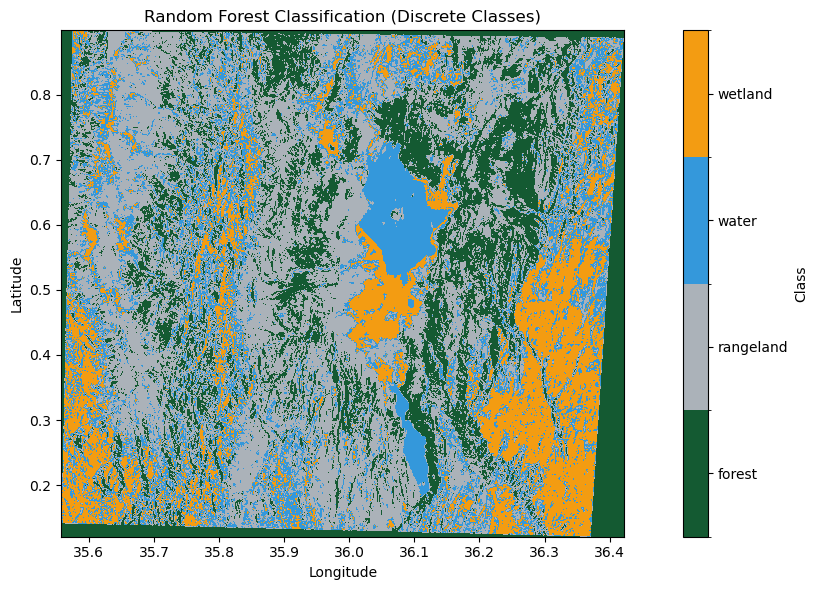

Area per class:
forest: 246,843.43 ha (2,468,434,344 m²)
rangeland: 260,221.48 ha (2,602,214,836 m²)
water: 33,936.66 ha (339,366,569 m²)
wetland: 242,244.63 ha (2,422,446,316 m²)


In [67]:
# Get class labels from LabelEncoder (in order)
class_labels = le.classes_

# Define colors for each class (add more if needed)
colors = ['#145a32', '#abb2b9', '#3498db', '#f39c12']  # adjust or extend if you have more classes
cmap = ListedColormap(colors[:len(class_labels)])

# Create discrete color normalization for the classes
bounds = np.arange(len(class_labels) + 1) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

# Plot the classified map
plt.figure(figsize=(12, 6))
im = plt.imshow(
    predicted_img,
    cmap=cmap,
    norm=norm,
    extent=[extent[0], extent[2], extent[1], extent[3]],
    origin='upper'
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Random Forest Classification (Discrete Classes)")
plt.gca().set_aspect('equal', adjustable='box')

# Add colorbar with class labels
cbar = plt.colorbar(im, ticks=np.arange(len(class_labels)))
cbar.ax.set_yticklabels(class_labels)
cbar.set_label("Class")

plt.tight_layout()
plt.show()

# If you want area in m² as well, compute from hectares
class_areas_m2 = {k: v * 10_000 for k, v in class_areas_ha.items()}

# Print area per class in ha and m²
print("Area per class:")
for class_name in class_labels:
    ha = class_areas_ha.get(class_name, 0)
    m2 = class_areas_m2.get(class_name, 0)
    print(f"{class_name}: {ha:,.2f} ha ({m2:,.0f} m²)")
